<a href="https://colab.research.google.com/github/exterm/uvm-pocs/blob/main/pocs4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
#plotting
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns 

import pandas as pd # library for data analysis
import numpy as np
import scipy.stats as stats
import scipy

import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import t

# Initialize Filesystem

In [2]:
from google.colab import drive
import os

drive.mount('/content/drive')

# create directory for this assignment
try: 
    os.mkdir('/content/drive/MyDrive/pocs/04/') 
except OSError as error: 
    print(error)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 17] File exists: '/content/drive/MyDrive/pocs/04/'


# Fetch Data

In [3]:
filepath1 = 'https://pdodds.w3.uvm.edu/teaching/courses/2022-2023pocsverse/docs/vocab_cs_mod.txt'
filepath2 = 'https://pdodds.w3.uvm.edu/teaching/courses/2022-2023pocsverse/docs/google_vocab_rawwordfreqs.txt'
vocab = pd.read_csv(filepath1, header=None, sep=' ', names=['k', 'Nk'])
vocab_raw = pd.read_csv(filepath2, header=None, sep=' ', names=['k'])


#1 Plot the complementary cumulative distribution function (CCDF).

In [4]:
vocab_cdfs = vocab.copy()
vocab_cdfs = vocab_cdfs.sort_values(by="k", ascending=False)

vocab_cdfs['CCDF'] = vocab_cdfs['Nk'].cumsum(0)

Plot $k$ on the $x$ axis and $N_\geq(k)$,  the number of words that have more than $k$ occurrences, on the $y$ axis.

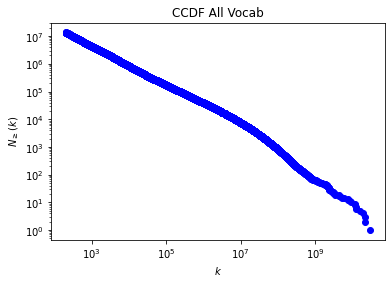

In [5]:
plt.plot('k','CCDF','bo', data=vocab_cdfs)
plt.loglog(base=10)
plt.ylabel('$N_\geq(k)$')
plt.xlabel('$k$')
plt.title("CCDF All Vocab")
plt.savefig('/content/drive/MyDrive/pocs/04/01-ccdf.png', dpi=600)
plt.show()

# 2. Using standard linear regression
* measure the exponent γ − 1 
* where γ is the exponent of the underlying distribution function. 
* Identify and use a range of frequencies for which scaling appears consistent. 
* Report the 95% confidence interval for your estimate.
* You will find two scaling regimes—please examine them both

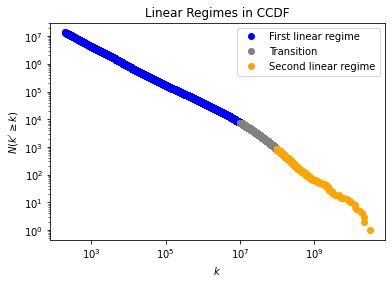

In [6]:
regime1 = vocab_cdfs[vocab_cdfs.k <= 10**7]
between = vocab_cdfs[(vocab_cdfs.k >= 10**7) & (vocab_cdfs.k <= 10**8)]
regime2 = vocab_cdfs[vocab_cdfs.k > 10**8]

plt.plot(regime1['k'], regime1['CCDF'], marker='o', lw=0, color='b', label='First linear regime')
plt.plot(between['k'], between['CCDF'], marker='o', lw=0, color='gray', label='Transition')
plt.plot(regime2['k'], regime2['CCDF'], marker='o', lw=0, color='orange', label='Second linear regime')
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regimes in CCDF")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/02-regimes.png', dpi=600)
plt.show()


In [7]:
def regression_confidence(percent, sample_size, regression_result):
  # we only have a sample, know nothing about the population, so we should use
  #  the t-statistic
  tinv = lambda p, df: abs(t.ppf(p/2, df))
  ts = tinv(1-(percent/100.), sample_size-2)
  print(f"slope ({percent}%): {regression_result.slope:.6f} +/- {ts*regression_result.stderr:.6f}")
  print(f"intercept ({percent}%): {regression_result.intercept:.6f}"
        f" +/- {ts*regression_result.intercept_stderr:.6f}")

In [8]:
# log-log regression
def regress_ll(x, y):
  result = stats.linregress(np.log10(x), np.log10(y))
  print(f"R squared: {result.rvalue**2}")
  regression_confidence(95, len(x), result)
  print()
  return result

Compute slope through linear regression, together with a $95\%$ confidence interval.


PDF: $N_k \sim k^{-\gamma}$

CCDF: $N_{\geq k} \sim k^{-(\gamma - 1)}$

$\Rightarrow \gamma = -\text{slope}_{CCDF} + 1 = 0.660553 \pm 0.000080$ ($95\%$ confidence)


In [9]:
print("-- Regime 1 --")
result1 = regress_ll(regime1['k'], regime1['CCDF'])

print("-- Regime 2 --")
result2 = regress_ll(regime2['k'], regime2['CCDF'])

-- Regime 1 --
R squared: 0.9991284965117176
slope (95%): -0.660553 +/- 0.000080
intercept (95%): 8.539718 +/- 0.000418

-- Regime 2 --
R squared: 0.9892567128645035
slope (95%): -1.049455 +/- 0.007529
intercept (95%): 11.272610 +/- 0.063158



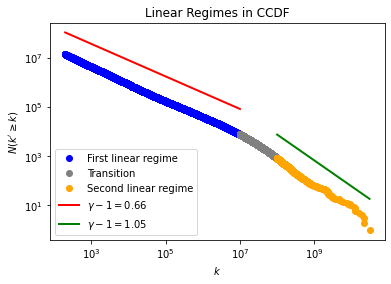

In [10]:
plt.plot(regime1['k'], regime1['CCDF'], marker='o', lw=0, color='b', label='First linear regime')
plt.plot(between['k'], between['CCDF'], marker='o', lw=0, color='gray', label='Transition')
plt.plot(regime2['k'], regime2['CCDF'], marker='o', lw=0, color='orange', label='Second linear regime')

# offset regression line for visibility
c_vocab = 10**result1.intercept*10
slope_CCDF = result1.slope
plt.plot(regime1['k'], c_vocab*np.power(regime1['k'], slope_CCDF), color='r', lw=2, label=r"$\gamma-1=%.2f$" % -slope_CCDF)

# offset regression line for visibility
c_vocab = 10**result2.intercept*10
slope_CCDF2 = result2.slope
plt.plot(regime2['k'], c_vocab*np.power(regime2['k'], slope_CCDF2), color='g', lw=2, label=r"$\gamma-1=%.2f$" % -slope_CCDF2)


plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regimes in CCDF")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/02-regressions.png', dpi=600)
plt.show()

#3 Size-rank plots:

Using the alternate data set providing the raw word frequencies, plot word
frequency as a function of rank in the manner of Zipf.
Hint: you will not be able to plot all points (there are close to 14 million) so
think about how to plot a subsample that still shows the full form.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.zipf.html

In [11]:
from scipy.stats import rankdata

In [12]:
vocab_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13588391 entries, 0 to 13588390
Data columns (total 1 columns):
 #   Column  Dtype
---  ------  -----
 0   k       int64
dtypes: int64(1)
memory usage: 103.7 MB


In [13]:
# sneaky use of negative sign to rank in reverse order
ranks = rankdata(-vocab_raw['k'])
vocab_raw_ranked = vocab_raw.copy()
vocab_raw_ranked["Rank"] = ranks
vocab_raw_ranked

,k,Rank
0,95119665584,1.5
1,95119665584,1.5
2,30578667846,3.0
3,22077031422,4.0
4,21594821357,5.0
...,...,...
13588386,200,13563242.5
13588387,200,13563242.5
13588388,200,13563242.5
13588389,200,13563242.5


In [14]:
vocab_raw_ranked_sampled = vocab_raw_ranked.sample(n=100_000, replace=False, random_state=1, weights=1/vocab_raw_ranked.Rank)
vocab_raw_ranked_sampled

,k,Rank
742,108535359,743.0
122554,164633,122555.0
0,95119665584,1.5
107,562231465,108.0
7,12765289150,8.0
...,...,...
132141,145981,132142.0
516748,18841,516755.0
4933361,801,4933002.0
316630,38186,316627.5


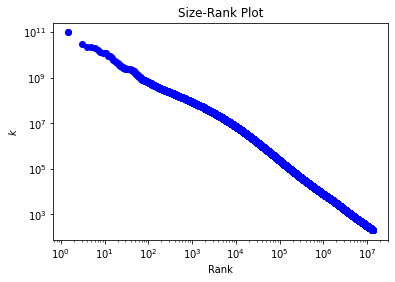

In [15]:
plt.plot(vocab_raw_ranked_sampled['Rank'], vocab_raw_ranked_sampled['k'], marker='o', lw=0, color='b')
plt.ylabel('$k$')
plt.xlabel('Rank')
plt.title("Size-Rank Plot")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/03-size-rank.png', dpi=600)
plt.show()

# 4. Using standard linear regression, measure α, Zipf’s exponent. Report the 95% confidence interval for your estimate.

Divide into two linear regimes.




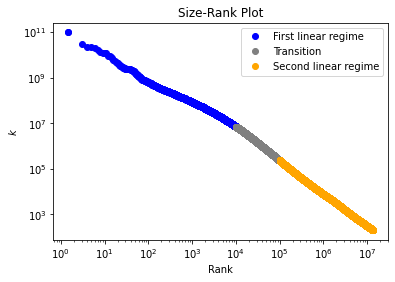

In [16]:
boundary1 = 10**4
boundary2 = 10**5
rregime1 = vocab_raw_ranked_sampled[vocab_raw_ranked_sampled.Rank < boundary1]
between = vocab_raw_ranked_sampled[(vocab_raw_ranked_sampled.Rank >= boundary1) & (vocab_raw_ranked_sampled.Rank <= boundary2)]
rregime2 = vocab_raw_ranked_sampled[vocab_raw_ranked_sampled.Rank > boundary2]

plt.plot(rregime1['Rank'], rregime1['k'], marker='o', lw=0, color='b', label='First linear regime')
plt.plot(between['Rank'], between['k'], marker='o', lw=0, color='gray', label='Transition')
plt.plot(rregime2['Rank'], rregime2['k'], marker='o', lw=0, color='orange', label='Second linear regime')
plt.legend()
plt.ylabel('$k$')
plt.xlabel('Rank')
plt.title("Size-Rank Plot")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/04-regimes.png', dpi=600)
plt.show()

Run two linear regressions.

Regime 1 measured: $\alpha = 1.016644 \pm 0.001578$ ($95\%$ confidence)

Regime 2 measured: $\alpha = 1.405881 \pm 0.000009$ ($95\%$ confidence)

In [17]:
print("-- Regime 1 --")
rregime1_unsampled = vocab_raw_ranked[vocab_raw_ranked.Rank < boundary1]
rresult1 = regress_ll(rregime1_unsampled['Rank'], rregime1_unsampled['k'])

print("-- Regime 2 --")
rregime2_unsampled = vocab_raw_ranked[vocab_raw_ranked.Rank > boundary2]
rresult2 = regress_ll(rregime2_unsampled['Rank'], rregime2_unsampled['k'])

-- Regime 1 --
R squared: 0.9937700708952248
slope (95%): -1.016644 +/- 0.001578
intercept (95%): 10.961179 +/- 0.005669

-- Regime 2 --
R squared: 0.999848036522939
slope (95%): -1.405881 +/- 0.000009
intercept (95%): 12.321773 +/- 0.000062



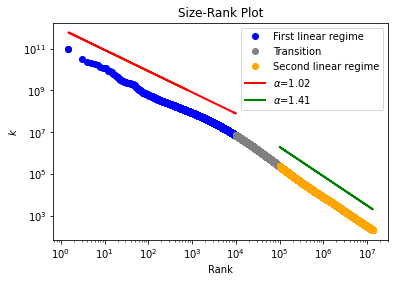

In [18]:
plt.plot(rregime1['Rank'], rregime1['k'], marker='o', lw=0, color='b', label='First linear regime')
plt.plot(between['Rank'], between['k'], marker='o', lw=0, color='gray', label='Transition')
plt.plot(rregime2['Rank'], rregime2['k'], marker='o', lw=0, color='orange', label='Second linear regime')

# offset regression line for visibility
c_vocab = 10**rresult1.intercept*10
alpha_vocab = -rresult1.slope
plt.plot(rregime1['Rank'], c_vocab*np.power(rregime1['Rank'], -alpha_vocab), color='r', lw=2, label=r"$\alpha$=%.2f" % alpha_vocab)

# offset regression line for visibility
c_vocab = 10**rresult2.intercept*10
alpha_vocab = -rresult2.slope
plt.plot(rregime2['Rank'], c_vocab*np.power(rregime2['Rank'], -alpha_vocab), color='g', lw=2, label=r"$\alpha$=%.2f" % alpha_vocab)

plt.legend()
plt.ylabel('$k$')
plt.xlabel('Rank')
plt.title("Size-Rank Plot")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/04-regressions.png', dpi=600)
plt.show()


#5 For each scaling regime, write down how γ and α are related (per lectures) and
check how this expression works for your estimates here

For the slope of the Zipf distribution we expect $\alpha = \frac{1}{\gamma - 1}$ where $\gamma$ is the slope of the PDF.

Regime 1 expectation: $\alpha \approx \frac{1}{2-1} = 1$. Measured: $1.02$

Regime 2 expectation: $\alpha \approx \frac{1}{\frac{5}{3}-1} = \frac{3}{2}$. Measured: $1.41$

It's a great match for regime 1, and about $5\%$ off for regime 2.


#6  (3 + 3) Baby name frequencies in the US:
Note: We will use this data set again in the next assignment.

(a) Plot the Complementary Cumulative Frequency Distributions and Size-rank
plots (Zipf’s law) for the following:
* i. Baby girl names in 1952.
* ii. Baby boy names in 1952.
* iii. Baby girl names in 2002.
* iv. Baby boy names in 2002.

Note that you will have counts that will make the Zipf distribution easy to
plot straight away.
From these counts, you will have to create the distributions Nk and N≥k.

In [19]:
Babygirl_1952 = pd.read_csv('/content/drive/MyDrive/pocs/data/names-girls1952.txt', header=None, names=['Name', 'Gender', 'k'])
Babyboy_1952 = pd.read_csv('/content/drive/MyDrive/pocs/data/names-boys1952.txt', header=None, names=['Name', 'Gender', 'k'])
Babygirl_2002 = pd.read_csv('/content/drive/MyDrive/pocs/data/names-girls2002.txt', header=None, names=['Name', 'Gender', 'k'])
Babyboy_2002 = pd.read_csv('/content/drive/MyDrive/pocs/data/names-boys2002.txt', header=None, names=['Name', 'Gender', 'k'])

todo: need to create an Nk column for each of these data frames to be able to do the ccdf, the nk is the counts of how many names appear n times

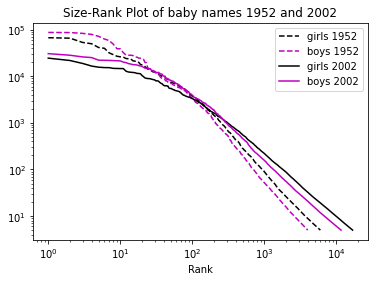

In [30]:
# sneaky use of negative sign to rank in reverse order
ranks_BG52 = rankdata(-Babygirl_1952['k'])
BG52_ranked = Babygirl_1952.copy()
BG52_ranked["Rank"] = ranks_BG52

ranks_BB52 = rankdata(-Babyboy_1952['k'])
BB52_ranked = Babyboy_1952.copy()
BB52_ranked["Rank"] = ranks_BB52

ranks_BG02 = rankdata(-Babygirl_2002['k'])
BG02_ranked = Babygirl_2002.copy()
BG02_ranked["Rank"] = ranks_BG02

ranks_BB02 = rankdata(-Babyboy_2002['k'])
BB02_ranked = Babyboy_2002.copy()
BB02_ranked["Rank"] = ranks_BB02

plt.plot(BG52_ranked['Rank'], BG52_ranked['k'], 'k--', label='girls 1952')
plt.plot(BB52_ranked['Rank'], BB52_ranked['k'], 'm--', label='boys 1952')
plt.plot(BG02_ranked['Rank'], BG02_ranked['k'], 'k-', label='girls 2002')
plt.plot(BB02_ranked['Rank'], BB02_ranked['k'], 'm-', label='boys 2002')
plt.legend()
plt.xlabel('Rank')
plt.title("Size-Rank Plot of baby names 1952 and 2002")

plt.loglog(base=10)
plt.savefig('/content/drive/MyDrive/pocs/04/06-size-rank.png', dpi=600)
plt.show()

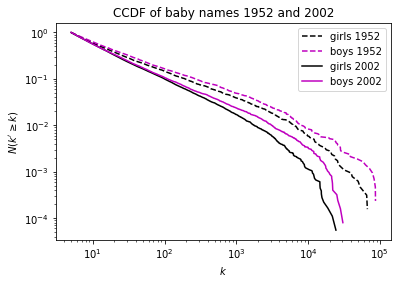

In [31]:
# unique values of k
# another array of same length that is how many ks have that values

uniques_g52, counts_g52 = np.unique(Babygirl_1952['k'], return_counts=True)
uniques_b52, counts_b52 = np.unique(Babyboy_1952['k'], return_counts=True)
uniques_g02, counts_g02 = np.unique(Babygirl_2002['k'], return_counts=True)
uniques_b02, counts_b02 = np.unique(Babyboy_2002['k'], return_counts=True)

# cdf = counts_g52.cumsum(0)/np.sum(counts_g52)
# CCDF_g52 = 1 - cdf #CCDF is just 1-CDF
# cdf = counts_b52.cumsum(0)/np.sum(counts_b52)
# CCDF_b52 = 1 - cdf #CCDF is just 1-CDF
# cdf = counts_g02.cumsum(0)/np.sum(counts_g02)
# CCDF_g02 = 1 - cdf #CCDF is just 1-CDF
# cdf = counts_b02.cumsum(0)/np.sum(counts_b02)
# CCDF_b02 = 1 - cdf #CCDF is just 1-CDF

CCDF_g52 = np.flip(np.flip(counts_g52).cumsum(0)/np.sum(counts_g52))
CCDF_b52 = np.flip(np.flip(counts_b52).cumsum(0)/np.sum(counts_b52))
CCDF_g02 = np.flip(np.flip(counts_g02).cumsum(0)/np.sum(counts_g02))
CCDF_b02 = np.flip(np.flip(counts_b02).cumsum(0)/np.sum(counts_b02))

plt.plot(uniques_g52, CCDF_g52, 'k--', label='girls 1952')
plt.plot(uniques_b52, CCDF_b52, 'm--', label='boys 1952')
plt.plot(uniques_g02, CCDF_g02, 'k-', label='girls 2002')
plt.plot(uniques_b02, CCDF_b02, 'm-', label='boys 2002')
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("CCDF of baby names 1952 and 2002")
plt.savefig('/content/drive/MyDrive/pocs/04/06-CCDF.png', dpi=600)
plt.show()


(b) As you did for the Google data set, fit regression lines and report values of γ
and the Zipf exponent α.
BUT: Only fit lines if fitting lines make sense!
You may only have one region of scaling or zero.

R squared: 0.9933483882044098


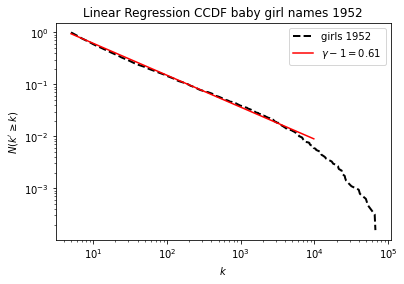

In [32]:
girls_1952 = pd.DataFrame(np.array([uniques_g52, CCDF_g52]).T, columns=['k', 'CCDF'])

linear_regime = girls_1952[girls_1952.k < 10**4]

res_g52 = stats.linregress(np.log10(linear_regime.k), np.log10(linear_regime.CCDF))
print(F"R squared: {res_g52.rvalue**2}")

plt.plot('k', 'CCDF', 'k--', data=girls_1952, label='girls 1952', lw=2)
plt.plot(linear_regime.k, (10**res_g52.intercept)*linear_regime.k**res_g52.slope, 'r', label=r'$\gamma - 1 = %.2f$' % -res_g52.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regression CCDF baby girl names 1952")
plt.savefig('/content/drive/MyDrive/pocs/04/06-g1952-ccdf.png', dpi=600)
plt.show()


R squared: 0.991682453183376


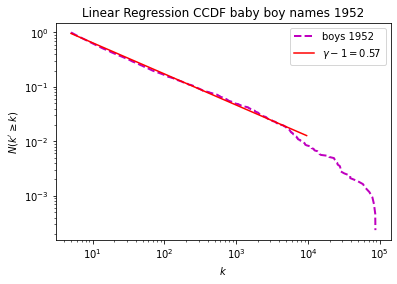

In [33]:
boys_1952 = pd.DataFrame(np.array([uniques_b52, CCDF_b52]).T, columns=['k', 'CCDF'])

linear_regime = boys_1952[boys_1952.k < 10**4]

res_b52 = stats.linregress(np.log10(linear_regime.k), np.log10(linear_regime.CCDF))
print(F"R squared: {res_b52.rvalue**2}")

plt.plot('k', 'CCDF', 'm--', data=boys_1952, label='boys 1952', lw=2)
plt.plot(linear_regime.k, (10**res_b52.intercept)*linear_regime.k**res_b52.slope, 'r', label=r'$\gamma - 1 = %.2f$' % -res_b52.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regression CCDF baby boy names 1952")
plt.savefig('/content/drive/MyDrive/pocs/04/06-b1952-ccdf.png', dpi=600)
plt.show()

R squared: 0.9978147917088019


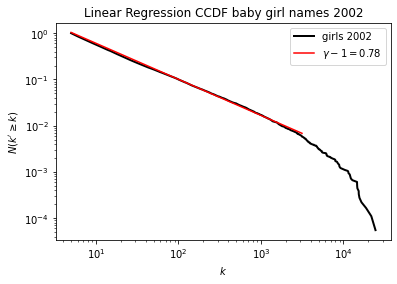

In [34]:
girls_2002 = pd.DataFrame(np.array([uniques_g02, CCDF_g02]).T, columns=['k', 'CCDF'])

linear_regime = girls_2002[girls_2002.k < 10**3.5]

res_g02 = stats.linregress(np.log10(linear_regime.k), np.log10(linear_regime.CCDF))
print(F"R squared: {res_g02.rvalue**2}")

plt.plot('k', 'CCDF', 'k-', data=girls_2002, label='girls 2002', lw=2)
plt.plot(linear_regime.k, (10**res_g02.intercept)*linear_regime.k**res_g02.slope, 'r', label=r'$\gamma - 1 = %.2f$' % -res_g02.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regression CCDF baby girl names 2002")
plt.savefig('/content/drive/MyDrive/pocs/04/06-g2002-ccdf.png', dpi=600)
plt.show()

R squared: 0.9955145769855089


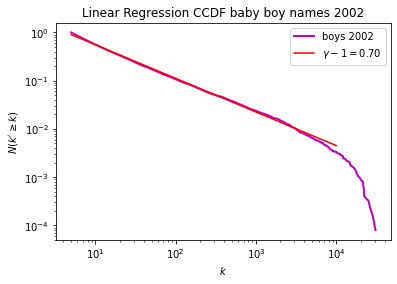

In [35]:
boys_2002 = pd.DataFrame(np.array([uniques_b02, CCDF_b02]).T, columns=['k', 'CCDF'])

linear_regime = boys_2002[boys_2002.k < 10**4]

res_b02 = stats.linregress(np.log10(linear_regime.k), np.log10(linear_regime.CCDF))
print(F"R squared: {res_b02.rvalue**2}")

plt.plot('k', 'CCDF', 'm-', data=boys_2002, label='boys 2002', lw=2)
plt.plot(linear_regime.k, (10**res_b02.intercept)*linear_regime.k**res_b02.slope, 'r', label=r'$\gamma - 1 = %.2f$' % -res_b02.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('$k$')
plt.title("Linear Regression CCDF baby boy names 2002")
plt.savefig('/content/drive/MyDrive/pocs/04/06-b2002-ccdf.png', dpi=600)
plt.show()

## Ranked

Girls 1952 expected $\alpha = \frac{1}{\gamma-1} \approx \frac{1}{0.61} \approx 1.639$, measured $\alpha = 1.65$.

R squared: 0.998359637326978


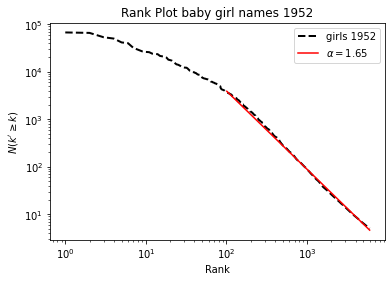

In [36]:
linear_regime = BG52_ranked[BG52_ranked.Rank > 10**2]

res_rg52 = stats.linregress(np.log10(linear_regime['Rank']), np.log10(linear_regime['k']))
print(F"R squared: {res_rg52.rvalue**2}")

plt.plot(BG52_ranked.Rank, BG52_ranked.k, 'k--', label='girls 1952', lw=2)
plt.plot(linear_regime.Rank, (10**res_rg52.intercept)*linear_regime.Rank**res_rg52.slope, 'r', label=r'$\alpha = %.2f$' % -res_rg52.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('Rank')
plt.title("Rank Plot baby girl names 1952")
plt.savefig('/content/drive/MyDrive/pocs/04/06-g1952-size-rank.png', dpi=600)
plt.show()


Boys 1952 expected $\alpha = \frac{1}{\gamma-1} \approx \frac{1}{0.57} \approx 1.75$, measured $\alpha = 1.79$.

R squared: 0.998706414133735


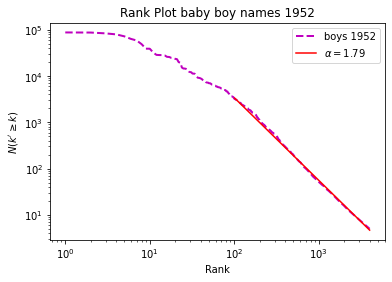

In [37]:
linear_regime = BB52_ranked[BB52_ranked.Rank > 10**2]

res_rb52 = stats.linregress(np.log10(linear_regime['Rank']), np.log10(linear_regime['k']))
print(F"R squared: {res_rb52.rvalue**2}")

plt.plot(BB52_ranked.Rank, BB52_ranked.k, 'm--', label='boys 1952', lw=2)
plt.plot(linear_regime.Rank, (10**res_rb52.intercept)*linear_regime.Rank**res_rb52.slope, 'r', label=r'$\alpha = %.2f$' % -res_rb52.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('Rank')
plt.title("Rank Plot baby boy names 1952")
plt.savefig('/content/drive/MyDrive/pocs/04/06-b1952-size-rank.png', dpi=600)
plt.show()


Girls 2002 expected $\alpha = \frac{1}{\gamma-1} \approx \frac{1}{0.78} \approx 1.28$, measured $\alpha = 1.33$.

R squared: 0.9996568917758782


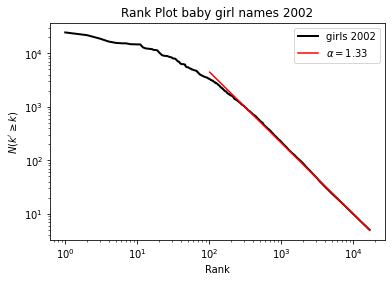

In [38]:
linear_regime = BG02_ranked[BG02_ranked.Rank > 10**2]

res_rg02 = stats.linregress(np.log10(linear_regime['Rank']), np.log10(linear_regime['k']))
print(F"R squared: {res_rg02.rvalue**2}")

plt.plot(BG02_ranked.Rank, BG02_ranked.k, 'k-', label='girls 2002', lw=2)
plt.plot(linear_regime.Rank, (10**res_rg02.intercept)*linear_regime.Rank**res_rg02.slope, 'r', label=r'$\alpha = %.2f$' % -res_rg02.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('Rank')
plt.title("Rank Plot baby girl names 2002")
plt.savefig('/content/drive/MyDrive/pocs/04/06-g2002-size-rank.png', dpi=600)
plt.show()

Boys 2002 expected $\alpha = \frac{1}{\gamma-1} \approx \frac{1}{0.7} \approx
1.428$, measured $\alpha = 1.42$.

R squared: 0.9988488767590942


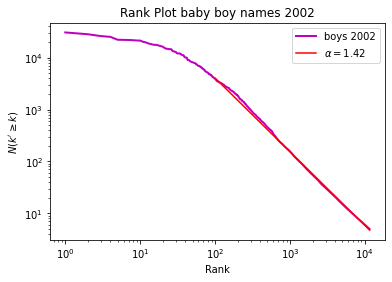

In [39]:
linear_regime = BB02_ranked[BB02_ranked.Rank > 10**2]

res_rb02 = stats.linregress(np.log10(linear_regime['Rank']), np.log10(linear_regime['k']))
print(F"R squared: {res_rb02.rvalue**2}")

plt.plot(BB02_ranked.Rank, BB02_ranked.k, 'm-', label='boys 2002', lw=2)
plt.plot(linear_regime.Rank, (10**res_rb02.intercept)*linear_regime.Rank**res_rb02.slope, 'r', label=r'$\alpha = %.2f$' % -res_rb02.slope)
plt.loglog(base=10)
plt.legend()
plt.ylabel('$N(k\'\geq k)$')
plt.xlabel('Rank')
plt.title("Rank Plot baby boy names 2002")
plt.savefig('/content/drive/MyDrive/pocs/04/06-b2002-size-rank.png', dpi=600)
plt.show()
